## Astronomy 406 "Computational Astrophysics" (Fall 2017)

### Week 9: Markov Chain Monte Carlo

<b>Reading:</b> notes below, as well as [$\S$15.8](https://umich.instructure.com/files/5261919/download?download_frd=1), [$\S$7.7-7.9](https://umich.instructure.com/files/5261918/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes/), and $\S$5.8 of [Machine Learning](http://www.astroml.org/).

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from astroML.plotting import hist

When the model we want to fit to a dataset has many parameters, direct maximization of the likelihood may be impractical.  In this case the Markov Chain Monte Carlo (MCMC) methods provide a powerful way of estimating the parameters of a model and their degree of uncertainty. MCMC is based on the ideas of Bayesian statistical inference.

Thomas Bayes wrote a manuscript (published posthumously in 1763) on how to combine an initial belief with new data to arrive at an improved belief.  This idea was rediscovered and popularized by Pierre Simon Laplace.  However, practical application of Bayesian methods became common only in the second half of the 20th century, with the rise of the computer.

Bayes's rule relates conditional probabilities of two random variables $p(y\,|\,x) \, p(x) = p(x\,|\,y) \, p(y)$.  

$p(y\,|\,x)$ reads <i>probability of $y$ given $x$</i>.  $p(y)$ is <i>marginal probability function</i>: $p(y) = \int p(y\,|\,x) \, p(x) dx$, which is the probability of $y$ marginalized over all (for all cases of) $x$.

When applied to a set of data points $D$ described by model $M$ (with parameters $\mathbf{x}$), this rule gives Bayes's theorem:

$$p(M\,|\,D) = \frac{p(D\,|\,M) \, p(M)}{p(D)}$$

where $p(D\,|\,M)$ is the familiar likelihood function (which is really the probability of a data set being drawn from the distribution given by the model).  The new part here is $p(M)$, the model <i>prior distribution function</i>.  This theorem combines the initial belief $p(M)$ and the probability that it generated the observed data set $p(D\,|\,M)$, to produce the improved belief $p(M\,|\,D)$, which is called the <i>posterior probability</i>.

The prior distribution containts the priors on model parameters $\mathbf{x}$ and other information $I$, for example the functional form: $p(M) = p(\mathbf{x}\,|\,I) p(I)$.  

Priors are typically taken to be <i>flat</i>: $p(x) = const$ for $x_{min} < x < x_{max}\,$ and $p(x) = 0$ otherwise; 

or <i>scale-invariant</i> (flat in $log x$): $p(x) \propto 1/x$.<br>
This means we can rescale our measurement units by a constant factor $a$ without affecting the probability: $p(x) dx = p(ax) d(ax)$.

The posterior can rewritten as $p(M\,|\,D) \equiv \pi(\mathbf{x}\,|\,D,I)$.  We would like to sample $\pi(\mathbf{x})$ to obtain the distribution of model parameters, but we can't do it directly because $\pi(\mathbf{x})$ is not properly normalized.  This is where MCMC comes to rescue.

Notes on the above cell:
Prob of y GIVEN x AND 

Joint prob of x AND y is given by both. For example, x being snow falls, y being Michigan winning football
Prob of x and Prob of y given x

We WERE finding prob of data given model. What we really want is the prob of the model given the data. We know the D, we want to know if prob of M is correct in that context.

P(M | D) -> Initial belief * model = refinement. Can ignore P(D), it's a constant.

P(M) = start (priors?). This is debatable, and this initial guess limits your outputs. Note that scale-invariant values should not depend on xmin or xmax.
input, feed in data (?)
P(M|D) goes out (posterior). Note that pi(x) is defined as the posterior distribution.

For next cell:
Going from i to i+1 or p(x_i+1 | x_i) is called a transition probability. Note this by itself is not symmetric. But multiplying it out makes it so.

<i>Monte Carlo</i> is in MCMC because it involves random samples, <i>Markov Chain</i> is because sampling algorithm depends only on the previous sample (the so-called Markov process): the probability of step from $\mathbf{x}_i$ to $\mathbf{x}_{i+1}$ depends only on $\mathbf{x}_i$ and not on all previous chain ($\mathbf{x}_{i-1}, \mathbf{x}_{i-2}, ...$).

The key concept of the MCMC method is statistical equilibrium. The method was developed by physicists to model thermodynamic properties of particle systems, in which approach to equlibrium depends on interaction between particles. Likewise, in the MCMC method the equilibrium distribution of points $\mathbf{x}_i$ that sample the target distribution is achieved by choosing appropriate transition probabilities. To reach equilibrium the transition probability must be symmetric: $p(\mathbf{x}_{i+1}\,|\,\mathbf{x}_i) \, \pi(\mathbf{x}_i) = p(\mathbf{x}_i\,|\,\mathbf{x}_{i+1}) \, \pi(\mathbf{x}_{i+1})$. 

This is called the detailed balance condition.  It guarantees that the chain will sample $\mathbf{x}$ in proportion to $\pi(\mathbf{x})$ ("ergodically").

The simplest MCMC algorithm is the Metropolis method. The Metropolis step takes a position $\mathbf{x}_i$ in parameter space to the position $\mathbf{x}_{i+1}$ using the following steps:

1. propose a new position $\mathbf{x}_c$ drawn from a multivariate Gaussian centered on the current position $\mathbf{x}_i$ (or any other function that can reach anywhere in the region of interest)
2. compute the probability of the new position $\pi(\mathbf{x}_c\,|\,D)$
3. draw a random number $r$ between 0 and 1 and if
$$ r < \frac{\pi(\mathbf{x}_c\,|\,D)}{\pi(\mathbf{x}_i\,|\,D)} $$
4. return $\mathbf{x}_c$ as $\mathbf{x}_{i+1}$, or otherwise repeat $\mathbf{x}_i$ as $\mathbf{x}_{i+1}$ (this repetition is important - we must create a new link in the chain).

The algorithm depends only on the ratio of posteriors, and thus works even when $\pi(\mathbf{x})$ is not normalized.

Let's take again our familiar example of linear regression.

In [2]:
Lgal, dLgal, Mgc, dMgc = np.loadtxt("DataFiles/gc_galaxy.dat", unpack=True)

ind = (Lgal > 9) 
x = Lgal[ind]; dx = dLgal[ind]; y = Mgc[ind]; dy = dMgc[ind];

Logarithms of the Likelihood, Prior distribution, and Posterior distribution:

In [3]:
def lnLikelihood(p):
    b = p[0]
    sig2 = max(p[1], 0.)
    a = p[2]
    w = 1./(sig2 + dy**2 + (b*dx)**2)
    twologL = np.sum(np.log(w) - w*(y-a-b*x)**2)   #No negative sign! Calculating true likelihoods...
    return twologL

def lnPrior(p):
    if not (-2 < p[0] < 2):
        return -np.inf   #Returning log(0) = -infinity, we are taking log likelihood
    if not (0 < p[1] < 2):
        return -np.inf
    if not (-100 < p[2] < 100):
        return -np.inf        
    return 0.0

def lnPosterior(p):
    return lnPrior(p) + lnLikelihood(p)

One step of the Metropolis algorithm:

In [4]:
def Metropolis_step(lnpost_function, p, lnpost_p, pcov, naccept):
    q = np.random.multivariate_normal(p, pcov)
    lnpost_q = lnpost_function(q)
    r = np.random.rand()
    if(r <= np.exp(lnpost_q-lnpost_p)):
        #accept new step
        naccept += 1
        return q, lnpost_q, naccept
    else:
        #reject new step and repeat old step
        return p, lnpost_p, naccept

Let's run a simple Markov chain with a fixed number of steps:

In [5]:
nsteps = 80000

# Starting point
p = np.array([1., 1., 1.])
# Proposal covariance
step = np.diag([0.0001, 0.0001, 0.0001])

lnpost_p = lnPosterior(p)
chain = np.empty((nsteps, len(p)))

# Number of accepted steps
na = 0
np.random.seed(0)

for n in range(nsteps):
    p, lnpost_p, na = Metropolis_step(lnPosterior, p, lnpost_p, step, na)
    chain[n] = p
    
# Compute the acceptance fraction.
acc = float(np.any(np.diff(chain, axis=0), axis=1).sum())/(len(chain)-1)
print 'mean acceptance fraction = {0:.4f}  (na = {1:.4f})'.format(acc, 1.*na/nsteps)

print 'b = {0:.3f} +- {1:.3f}  sig = {2:.3f} +- {3:.3f}  a = {4:.3f} +- {5:.3f}'\
  .format(np.mean(chain[:,0]), np.std(chain[:,0]), \
   np.mean(chain[:,1]), np.std(chain[:,1]), \
   np.mean(chain[:,2]), np.std(chain[:,2]))

mean acceptance fraction = 0.1787  (na = 0.1787)
b = 1.329 +- 0.172  sig = 0.157 +- 0.064  a = -5.620 +- 1.776


Let's compare the inferred values of the parameters with the Maximum Likelihood method from previous notebook.

In [6]:
def neglnLikelihood(p):
    return -lnLikelihood(p)

o = optimize.minimize(neglnLikelihood, [1.,0.1,1.])

b = o.x[0]; sig = o.x[1]; a = o.x[2]
db = np.sqrt(o.hess_inv[0,0])
dsig = np.sqrt(o.hess_inv[1,1])
da = np.sqrt(o.hess_inv[2,2])
                      
print 'b = %.3f +- %.3f  sig = %.3f +- %.3f  a = %.3f +- %.3f' % (b, db, sig, dsig, a, da)

b = 1.435 +- 0.036  sig = 0.135 +- 0.010  a = -6.711 +- 0.374


They are not as accurate, but agree within the estimated errors of the MCMC parameters. Here is the first lesson: MCMC is the <b>worst</b> method to estimate model parameters. You use it only when nothing else works (such as when you have many more than 3 parameters).

Here is how our parameters have changed along the chain:

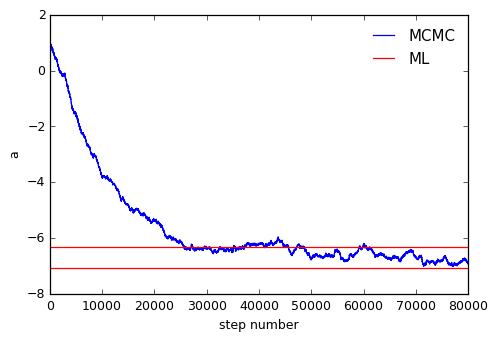

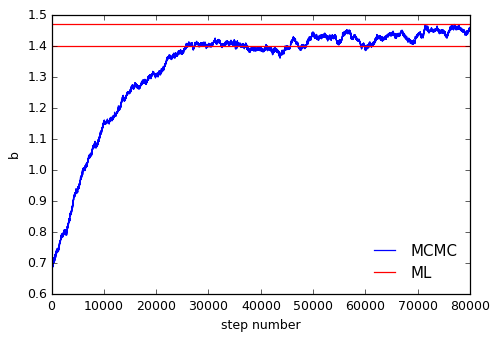

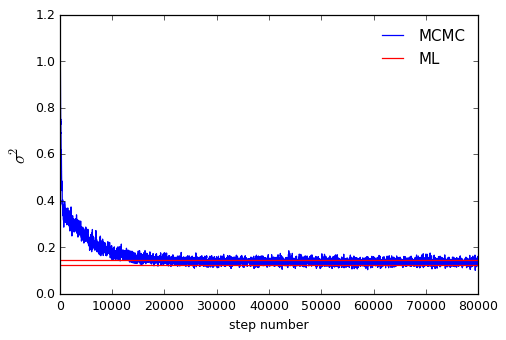

In [7]:
plt.plot(chain[:,2], 'b', label='MCMC')
plt.axhline(a-da, color='r', label='ML')
plt.axhline(a+da, color='r')
plt.xlabel('step number')
plt.ylabel('a')
plt.legend(frameon=False)
plt.show()

plt.plot(chain[:,0], 'b', label='MCMC')
plt.axhline(b-db, color='r', label='ML')
plt.axhline(b+db, color='r')
plt.xlabel('step number')
plt.ylabel('b')
plt.legend(frameon=False, loc=4)
plt.show()

plt.plot(chain[:,1], 'b', label='MCMC')
plt.axhline(sig-dsig, color='r', label='ML')
plt.axhline(sig+dsig, color='r')
plt.xlabel('step number')
plt.ylabel('$\sigma^2$', size=14)
plt.legend(frameon=False)
plt.show()

## We can see that the parameters gradually approach the values expected from the ML solution. However, the beginning of the MCMC chain is likely to be far from the maximum of the posterior probability distribution (otherwise we already know the answer!). These low-probability steps are very unlikely to be reached under correct sampling of a reasonable finite length of the chain, and therefore their presence biases the sampling of the posterior. The solution is to remove (burn-in) some initial part of the chain.

The simplest, but not the best, way to decide how much of the chain to burn-in is to look at the plots above. About 20000 steps seems right. We will consider below how to determine the burn-in length based on the autocorrelation analysis.

The next issue to decide is how long to continue running the chain. One way is based on the convergence of the parameters after the burn-in phase. It is implemented below. We take a chunk of 20000 steps and recalculate the inferred parameter values from the whole chain. If they differ by more than 0.001 (arbitrary choice) from the previous iteration, we continue adding another chunk.

In [8]:
nstepsmax = 400000
nburn = 20000
ncheck = 20000

# Starting point
p = np.array([1., 1., 1.])
# Proposal covariance
step = np.diag([0.0001, 0.0001, 0.0002])

pmean = np.zeros(len(p))
pstd = np.zeros(len(p))
nconv = np.zeros(len(p), dtype=int)
converged = (pmean > 1)
not_converged = True
nnext = nburn + ncheck

lnpost_p = lnPosterior(p)
chain2 = np.empty((nstepsmax, len(p)))
n, na = 0, 0
np.random.seed(0)

while not_converged and n < nstepsmax:
    p, lnpost_p, na = Metropolis_step(lnPosterior, p, lnpost_p, step, na)
    chain2[n] = p    
    n += 1
    
    if n >= nnext:
        pmean_last = np.copy(pmean)
        pstd_last = np.copy(pstd)
        pmean = np.mean(chain2[nburn:n], axis=0)
        pstd = np.std(chain2[nburn:n], axis=0, ddof=1)

        for i in range(len(p)):
            if(not converged[i] and abs(pmean[i]-pmean_last[i]) < 0.001):
                converged[i] = True
                nconv[i] = n
              
        if(converged[0] and converged[1] and converged[2]):
            not_converged = False

        print 'n = %4d: b = %.3f +- %.3f  s = %.3f +- %.3f  a = %.3f +- %.3f  acc = %.3f' \
               %(n, pmean[0], pstd[0], pmean[1], pstd[1], pmean[2], pstd[2], 1.*na/nsteps)
        nnext += ncheck       

print 'chain converged at [b]=%d [sig]=%d [a]=%d' % (nconv[0], nconv[1], nconv[2])


#More points are accepted (acc increases), the chain is randomly walking...
#But with higher acc we get closer and get to values that are more probable to be accepted

n = 40000: b = 1.444 +- 0.019  s = 0.136 +- 0.011  a = -6.804 +- 0.195  acc = 0.092
n = 60000: b = 1.444 +- 0.019  s = 0.136 +- 0.010  a = -6.799 +- 0.193  acc = 0.135
n = 80000: b = 1.445 +- 0.018  s = 0.136 +- 0.010  a = -6.814 +- 0.184  acc = 0.178
n = 100000: b = 1.445 +- 0.018  s = 0.136 +- 0.010  a = -6.809 +- 0.189  acc = 0.220
n = 120000: b = 1.443 +- 0.018  s = 0.136 +- 0.010  a = -6.791 +- 0.188  acc = 0.261
n = 140000: b = 1.442 +- 0.020  s = 0.136 +- 0.010  a = -6.776 +- 0.204  acc = 0.303
n = 160000: b = 1.444 +- 0.022  s = 0.136 +- 0.010  a = -6.804 +- 0.225  acc = 0.344
n = 180000: b = 1.451 +- 0.028  s = 0.136 +- 0.010  a = -6.869 +- 0.286  acc = 0.386
n = 200000: b = 1.446 +- 0.030  s = 0.136 +- 0.010  a = -6.822 +- 0.313  acc = 0.427
n = 220000: b = 1.447 +- 0.029  s = 0.136 +- 0.010  a = -6.828 +- 0.301  acc = 0.468
n = 240000: b = 1.449 +- 0.029  s = 0.136 +- 0.010  a = -6.848 +- 0.301  acc = 0.509
n = 260000: b = 1.448 +- 0.029  s = 0.136 +- 0.010  a = -6.844 +- 0.

Let's plot the parameter distributions. There are MANY links in the chain, and so a simple histogram with Knuth's rule would look too fragmented.  It is better to visualize the distributions with a Kernel Density Estimator.

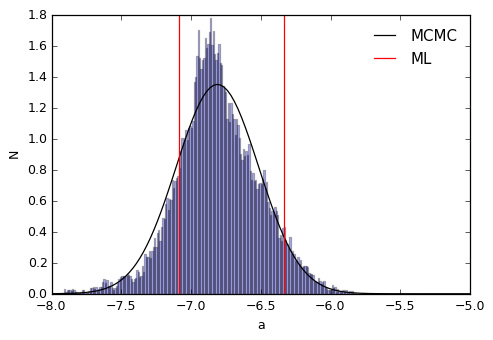

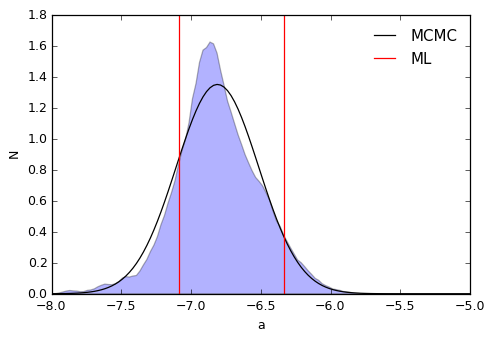

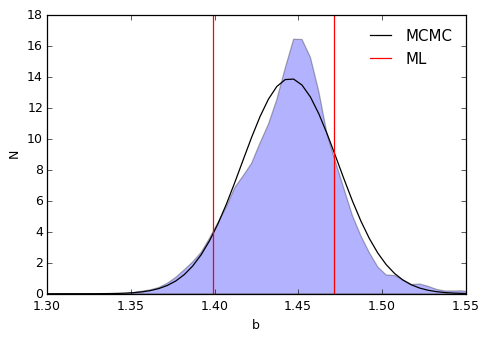

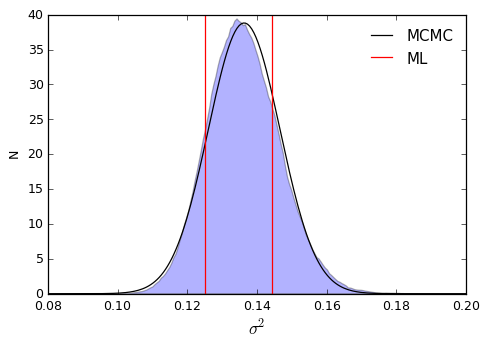

In [9]:
def kde_tophat( data, x, h ):
    y = (abs(x - data[:,None]) <= h).astype(float)
    return y.sum(0)/(2*h*len(data))

def pdf_gauss( x, mu, s ):
    return np.exp(-((x-mu)/s)**2/2)/(np.sqrt(2*np.pi)*s)

xx = np.linspace(-9, -4, 200)
hist(chain2[nburn:n,2], bins='knuth', alpha=0.3, normed=True)
plt.plot(xx, pdf_gauss(xx, pmean[2], pstd[2]), '-k', label='MCMC')
plt.axvline(a-da, color='r', label='ML')
plt.axvline(a+da, color='r')
plt.xlim(-8, -5)
plt.xlabel('a')
plt.ylabel('N')
plt.legend(frameon=False)
plt.show()

plt.fill(xx, kde_tophat(np.array(chain2[nburn:n,2]), xx, 0.05), alpha=0.3)
plt.plot(xx, pdf_gauss(xx, pmean[2], pstd[2]), '-k', label='MCMC')
plt.axvline(a-da, color='r', label='ML')
plt.axvline(a+da, color='r')
plt.xlim(-8, -5)
plt.xlabel('a')
plt.ylabel('N')
plt.legend(frameon=False)
plt.show()

xx = np.linspace(1, 2, 200)
plt.fill(xx, kde_tophat(np.array(chain2[nburn:n,0]), xx, 0.005), alpha=0.3)
plt.plot(xx, pdf_gauss(xx, pmean[0], pstd[0]), '-k', label='MCMC')
plt.axvline(b-db, color='r', label='ML')
plt.axvline(b+db, color='r')
plt.xlim(1.3, 1.55)
plt.xlabel('b')
plt.ylabel('N')
plt.legend(frameon=False)
plt.show()

xx = np.linspace(0.08, 0.2, 200)
plt.fill(xx, kde_tophat(np.array(chain2[nburn:n,1]), xx, 0.002), alpha=0.3)
plt.plot(xx, pdf_gauss(xx, pmean[1], pstd[1]), '-k', label='MCMC')
plt.axvline(sig-dsig, color='r', label='ML')
plt.axvline(sig+dsig, color='r')
plt.xlim(0.08, 0.2)
plt.xlabel('$\sigma^2$', size=14)
plt.ylabel('N')
plt.legend(frameon=False)
plt.show()

An efficient implementation of MCMC ensemble sampler is the [<b>emcee</b>](http://dan.iel.fm/emcee/current/) package.  Here is how one could use for our example above.

In [10]:
import emcee

ndim = 3
nwalkers = 100
nsteps = 10000
nburn = 200
np.random.seed(0)

# Choose an initial set of positions for the walkers
p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]

# Initialize the sampler with the chosen specs
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior)

# Run burn-in steps
pos, prob, state = sampler.run_mcmc(p0, nburn)

# Reset the chain to remove the burn-in samples
sampler.reset()

# Starting from the final position in the burn-in chain, sample nsteps
sampler.run_mcmc(pos, nsteps, rstate0=state)

# Print out the mean acceptance fraction among all walkers
print "Mean acceptance fraction = %.3f" % np.mean(sampler.acceptance_fraction)

# Estimate the integrated autocorrelation time for the time series in each parameter.
print "Autocorrelation length =", sampler.get_autocorr_time()

print "b = {0:.3f} +- {1:.3f}  s = {2:.3f} +- {3:.3f}  a = {4:.3f} +- {5:.3f}"\
  .format(np.mean(sampler.flatchain[:,0]), np.std(sampler.flatchain[:,0]), \
   np.mean(sampler.flatchain[:,1]), np.std(sampler.flatchain[:,1]), \
   np.mean(sampler.flatchain[:,2]), np.std(sampler.flatchain[:,2]))

Mean acceptance fraction = 0.646
Autocorrelation length = [ 30.46413101  28.12654219  30.21226716]
b = 1.435 +- 0.028  s = 0.136 +- 0.010  a = -6.708 +- 0.290


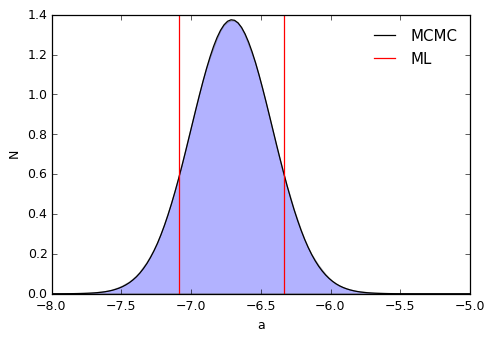

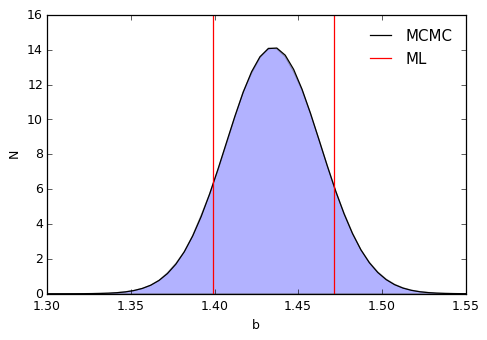

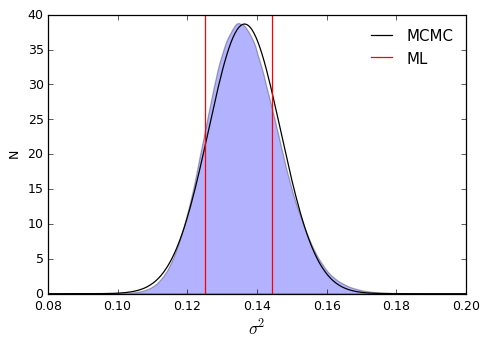

In [11]:
#sampler.chain = 2D thing with nsteps and nwalkers
#sampler.flatchain is still 2D b/c it has num params, and it is length of data for param

xx = np.linspace(-9, -4, 200)
plt.fill(xx, kde_tophat(np.array(sampler.flatchain[:,2]), xx, 0.05), alpha=0.3)
plt.plot(xx, pdf_gauss(xx, np.mean(sampler.flatchain[:,2]), np.std(sampler.flatchain[:,2])), '-k', label='MCMC')
plt.axvline(a-da, color='r', label='ML')
plt.axvline(a+da, color='r')
plt.xlim(-8, -5)
plt.xlabel('a')
plt.ylabel('N')
plt.legend(frameon=False)
plt.show()

xx = np.linspace(1, 2, 200)
plt.fill(xx, kde_tophat(np.array(sampler.flatchain[:,0]), xx, 0.005), alpha=0.3)
plt.plot(xx, pdf_gauss(xx, np.mean(sampler.flatchain[:,0]), np.std(sampler.flatchain[:,0])), '-k', label='MCMC')
plt.axvline(b-db, color='r', label='ML')
plt.axvline(b+db, color='r')
plt.xlim(1.3, 1.55)
plt.xlabel('b')
plt.ylabel('N')
plt.legend(frameon=False)
plt.show()

xx = np.linspace(0.08, 0.2, 200)
plt.fill(xx, kde_tophat(np.array(sampler.flatchain[:,1]), xx, 0.002), alpha=0.3)
plt.plot(xx, pdf_gauss(xx, np.mean(sampler.flatchain[:,1]), np.std(sampler.flatchain[:,1])), '-k', label='MCMC')
plt.axvline(sig-dsig, color='r', label='ML')
plt.axvline(sig+dsig, color='r')
plt.xlim(0.08, 0.2)
plt.xlabel('$\sigma^2$', size=14)
plt.ylabel('N')
plt.legend(frameon=False)
plt.show()

A pretty way to plot the parameter distributions is provided by the <b>corner</b> package. You can install in your python distribution by typing <tt>pip install corner</tt> in python command prompt.

2.0.1


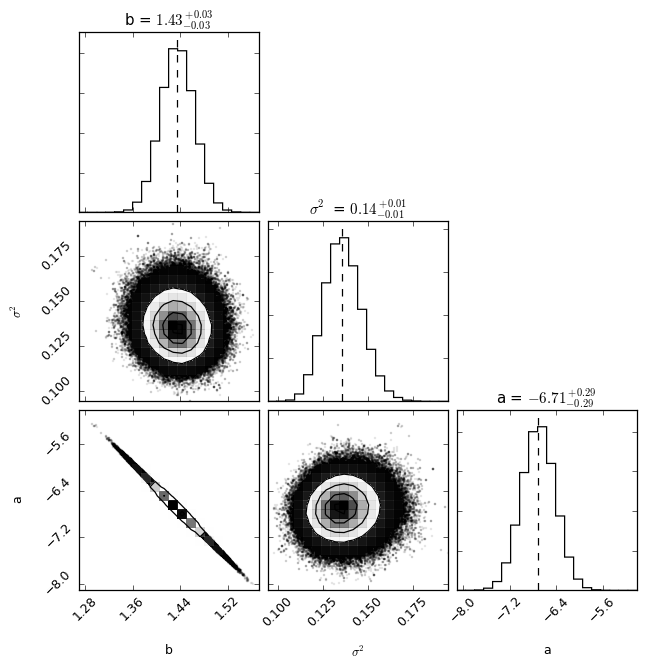

In [12]:
import corner
print corner.__version__

corner.corner(sampler.flatchain, labels=['b', r'$\sigma^2$', 'a'], quantiles=[0.5], show_titles=True)
plt.show()

#You can make the corner plot yourself using sampler.flatchain
#You can also plot scatter plot flatchain[0], flatcain[2], same with histogram, etc

Let's look at a part of the chain (for the first parameter).  Note that it has correlated values over a certain interval of steps.

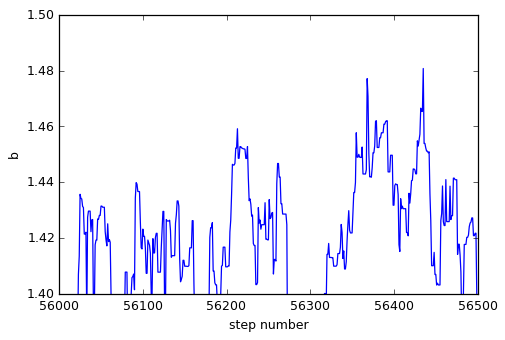

In [17]:
plt.xlabel('step number')
plt.ylabel('b')
plt.xlim(56000, 56500)
plt.ylim(1.4, 1.5)
plt.plot(sampler.flatchain[:,0], 'b')
plt.show()

The autocorrelation length calculated by <b>emcee</b> is about 40.  Do you see features of this size on the plot?

Indeed! 40 is the avg length between features (dips and peaks) of the chain.

Each feature will be represented by values over 40 steps. A big peak means these values over 40 steps are similar
...thus they are NOT independent of each other.

### Auto-correlation length

MCMC chains are correlated over a large number of steps, because in each step they change only by a small amount. In order to derive the true distribution of parameters, we need to obtain independent samples. One measure of independence of the values in the chain is the auto-correlation time. It can be used to determine both the <i>burn-in</i> sample at the beginning of the chain, and the frequency of <i>thinning</i> the chain.

Let's consider a Markov chain that has reached equilibrium state with the posterior distribution $\pi(\mathbf{x})$. The average value of some function $f(\mathbf{x})$ of the parameters $\mathbf{x}(t)$ is proportional to the sum over the chain:

$$ \langle f\rangle \propto \sum_i \pi(\mathbf{x}_i)\, f(\mathbf{x}_i). $$

The auto-correlation function is defined as 

$$ C(t) = \langle{\left[{ f(\mathbf{x}(t_0)) - \langle f(\mathbf{x}(t_0)) \rangle }\right]
\left[{ f(\mathbf{x}(t_0+t)) - \langle f(\mathbf{x}(t_0+t)) \rangle }\right] }\rangle
= \langle f(0)\,f(t) \rangle - \langle f \rangle^2. $$

A typical asymptotic behavior for large $t$ is 

$$ C(t) \sim \exp\left(-\frac{t}{\tau_{\rm exp}}\right) $$ 

where $\tau_{\rm exp}$ is the exponential autocorrelation time.

The length of the burn-in can be based on the number of correlated steps $N_{\rm corr} \approx \tau_{\rm exp}$. [Sokal (1996)](http://www.stat.unc.edu/faculty/cji/Sokal.pdf) recommends to discard the first $N_{\rm burn} = 20 N_{\rm corr}\,$ steps.

After removing the first $N_{\rm burn}\,$ steps, the remaining number of independent samples for a chain of total length $N_{\rm tot}$ is 

$$ N_{\rm ind} \approx \frac{N_{\rm tot} - N_{\rm burn}}{N_{\rm corr}}. $$

Thus the chain can be <i>thinned</i> by selecting only one of each $N_{\rm corr}$ steps. We would use such thinned chain to estimate the distribution of the parameters. The expected relative accuracy of estimating the parameter values from the posterior distribution is $N_{\rm ind}^{-1/2}$. For example, a $0.1\%$ accuracy requires the total length of the chain $N_{\rm tot} \approx 10^6\, N_{\rm corr} + N_{\rm burn}$.

Let's determine the length of the emcee chain that reaches the 0.1% relative accuracy of our parameters.

In [27]:
ndim = 3
nwalkers = 100
nsteps = 200   #Whatever ncorr is, then you have to increase nsteps in order to fit properly
#...alt: don't calculate first few steps
nburn = 200
np.random.seed(0)

# Choose an initial set of positions for the walkers
p0 = [np.random.rand(ndim) for i in xrange(nwalkers)]

# Initialize the sampler with the chosen specs
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior)

# Run burn-in steps
pos, prob, state = sampler2.run_mcmc(p0, nburn)

# Reset the chain to remove the burn-in samples
sampler2.reset()

pmean = np.zeros(len(p))
pstd = np.zeros(len(p))
nconv = np.zeros(len(p), dtype=int)
converged = (pmean > 1)
not_converged = True
nchain = nburn

while not_converged:
    pos, prob, state = sampler2.run_mcmc(pos, nsteps, rstate0=state)
    
    nchain += nsteps
    if nchain > 3000:
        ncorr = int(np.max(sampler2.get_autocorr_time()))

    pmean_last = np.copy(pmean)
    pstd_last = np.copy(pstd)
    pmean = np.mean(sampler2.flatchain[::ncorr], axis=0)
    pstd = np.std(sampler2.flatchain[::ncorr], axis=0, ddof=1)

    for i in range(len(p)):
        if not converged[i] and abs((pmean[i]-pmean_last[i])/pmean[i]) < 0.0004:
            converged[i] = True
            nconv[i] = nchain
              
    if converged[0] and converged[1] and converged[2]:
        not_converged = False

    print "b = {0:.3f} +- {1:.3f}  s = {2:.3f} +- {3:.3f}  a = {4:.3f} +- {5:.3f}  ncorr = {6:d} nchain = {7:d}"\
        .format(pmean[0], pstd[0], pmean[1], pstd[1], pmean[2], pstd[2], ncorr, nchain)

b = 1.436 +- 0.026  s = 0.136 +- 0.011  a = -6.721 +- 0.270  ncorr = 55 nchain = 400
b = 1.435 +- 0.028  s = 0.136 +- 0.010  a = -6.709 +- 0.292  ncorr = 55 nchain = 600
b = 1.434 +- 0.029  s = 0.137 +- 0.011  a = -6.703 +- 0.294  ncorr = 55 nchain = 800
b = 1.435 +- 0.027  s = 0.137 +- 0.011  a = -6.710 +- 0.279  ncorr = 55 nchain = 1000
b = 1.436 +- 0.028  s = 0.137 +- 0.010  a = -6.714 +- 0.288  ncorr = 55 nchain = 1200
b = 1.435 +- 0.028  s = 0.137 +- 0.010  a = -6.707 +- 0.291  ncorr = 55 nchain = 1400
b = 1.436 +- 0.029  s = 0.137 +- 0.011  a = -6.714 +- 0.293  ncorr = 55 nchain = 1600
b = 1.436 +- 0.028  s = 0.137 +- 0.010  a = -6.716 +- 0.290  ncorr = 55 nchain = 1800


Compare with the ML result:

In [18]:
print 'b = %.3f +- %.3f  sig = %.3f +- %.3f  a = %.3f +- %.3f' % (b, db, sig, dsig, a, da)

b = 1.435 +- 0.036  sig = 0.135 +- 0.010  a = -6.711 +- 0.374


The ML and MCMC results are completely consistent with each other, within their estimated errors.